In [1]:
import numpy as np 
from math import sqrt, erfc, log
from matplotlib import pyplot as plt
%matplotlib inline
from astropy.stats import bayesian_blocks
from os.path import expanduser


In [2]:
home = expanduser('~')
gc_dir = home + "/Dropbox/GalacticCenter/"

<h2> Extract and plot points from lightcurve 

In [3]:
# set the energy limits 
E = 0 

In [4]:
# extract the lightcurve data points

lc_data = np.genfromtxt(gc_dir+"/results/lightcurve_SgrA_daily_points_v254.txt") 
#lc_data = np.genfromtxt(gc_dir+"/log/lightCurves/SgrA_lightCurve_both_4tels_all_E"+str(E)+"_annual_points.txt")
#lc_data = np.genfromtxt(gc_dir+"/log/lightCurves/SgrA_lightCurve_both_E"+str(E)+"_annual_points.txt")

lc_data_points = []
for i in range(len(lc_data[:,0])):
    if lc_data[i,3] != 0 and lc_data[i,1] > 0.: # 
        lc_data_points.append(lc_data[i,:])

lc_data_points = np.array(lc_data_points) 


MJD_array = np.array(lc_data_points[:,0], dtype=np.float64)
flux_obs_array = np.array(lc_data_points[:,1], dtype=np.float64) #  / (m^2 * s)
flux_err_array = np.array(lc_data_points[:,2], dtype=np.float64)
livetime_array = np.array(lc_data_points[:,3], dtype=np.float64)

#print(flux_obs_array)
#log = list(map(lambda l: np.log10(l), _array))


In [5]:
fluxtime_array = flux_obs_array * livetime_array

# find the total livetime and mean flux 
total_livetime = np.sum(livetime_array)
mean_flux = np.sum(fluxtime_array) / total_livetime
print(mean_flux)


1.52098902472e-08


In [6]:
#lc_data = list(filter((0).__ne__, )

#flux_obs_array[ flux_obs_array==0 ] = np.nan
#flux_err_array[ flux_err_array==0 ] = np.nan
#fluxtime_array[ fluxtime_array==0 ] = np.nan

# remove empty points, marked as 0's 
#flux_obs_array = np.array(list(filter((0.0).__ne__, lc_data[:,1])), dtype=np.float64)
#flux_err_array = np.array(list(filter((0.0).__ne__, lc_data[:,2])), dtype=np.float64)
#livetime_array = np.array(list(filter((0.0).__ne__, lc_data[:,3])), dtype=np.float64)


/Users/mbuchove/Programs/Anaconda3/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


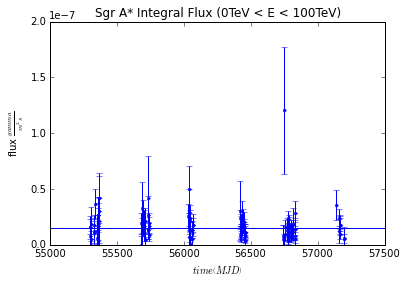

In [7]:
plt.errorbar(MJD_array, flux_obs_array, yerr=flux_err_array, fmt='b.') # 

plt.title("Sgr A* Integral Flux ("+str(E)+"TeV < E < 100TeV)")
plt.xlabel(r"$time\left(MJD\right)$")
plt.ylabel(r"flux $\frac{gamma}{m^{2}s}$") # gamma / m^2*s*TeV
#plt.xlim(1.5e0, 5.e1)
plt.ylim(ymin=0.)
plt.axhline(mean_flux)

#! MAY NEED TO REPLOT E0?  
#plt.savefig(gc_dir+"/plots/lightCurve/SgrA_lightcurve_all_4tels_seasonal.png")
#plt.savefig(gc_dir+"/plots/lightCurve/SgrA_lightcurve_all_4tels_E"+str(E)+"_seasonal.png")


<h2> Sliding window

In [50]:

def S_win(Nw, No, alpha):
    """calculates significance of deviation of flux 
    Nw: excess counts inside window
    No: excess counts outside window
    alpha: ratio of window duration to duration outside of window"""
    
    return (Nw - alpha*No)/sqrt(Nw + alpha**2*No)

def S_anna(N_on_w, N_off_w, N_on_b, N_off_b, alpha_w, alpha_b):
    """(N_w - a*N_b) / sqrt( N_on_w + a_w^2*N_off_w + a^2( N_on_b * a_b^2*N_off_b ) )"""
    
    return 

def P_pre(S):
    """the chance probability calculated from significance for a window"""
    
    return erfc(S/sqrt(2))

def P_post(P_pre, N):
    """post-trials probability after applying trials factors"""

    return 1 - (1-P_pre)**N

def S_LiMa(Non, Noff, alpha):
    """returns the Li and Ma significance (1983, equation 17)"""
    
    ln = log 
    
    on_term = Non * ln( (1+alpha)/alpha * Non/(Non+Noff) )
    off_term = Noff * ln( (1+alpha) * Noff / (Non+Noff) )
    
    #print(on_term)
    #print(off_term)
    #print(on_term+off_term)
    
    return sqrt(2*(on_term + off_term))

def S_err(flux, avg, err):
    """"""
    
    return (flux - avg) / err 


In [10]:
#def weighted_mean 

# window slider using generators 
def window_slide(iter, size=2):
    mem = [None] * size
    for i, each in enumerate(iter):
        mem[i % size] = each
        if i >= size - 1:
            yield mem[(i + 1) % size:] + mem[:(i + 1) % size]

-0.000552946230993


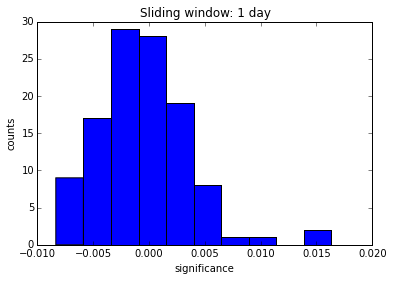

In [65]:
N = len(lc_data_points)
n = 1 # window size 

Ntot = np.sum(fluxtime_array)
Sig_windows = []
sigtime = 0

for i in range(N):
    Nw = np.sum(fluxtime_array[i:(i+n)])
    No = Ntot - Nw
    Tw = np.sum(livetime_array[i:(i+n)])
    To = total_livetime - Tw
    flux_w = Nw / Tw
    flux_o = No / To 
    alpha = Tw / To 
    
    #sig = S_anna()
    #sig = S_win(Nw, No, alpha) 
    #sig = S_LiMa(Nw, No, alpha)    
    #if flux_w < flux_o:
    #    sig *= -1 
    sig = S_err(flux_obs_array[i], flux_err_array[i])
    
    Sig_windows.append(sig)
    sigtime += sig * Tw
    
#print(Sig_windows)
#sig_hist = plt.hist(Sig_windows)

p_hist, bin_edges = np.histogram(Sig_windows, density=True)
#print(bin_edges)
#print(p_hist)


        
plt.hist(Sig_windows)
plt.title("Sliding window: " + str(n) + " day")
plt.xlabel("significance")
plt.ylabel("counts")

plt.savefig(gc_dir + "/plots/sliding_window/SW_sig_LiMa_" + str(n) +"day.png")

print(sigtime/total_livetime)


In [12]:
# fit hist to Gaussian 
from scipy.optimize import curve_fit

def gauss_norm(x, x0, sigma, A=1):
    """normalized 1D gaussian function"""
    return A/(np.sqrt(2*np.pi))*np.exp(-((x-x0)/sigma)**2/2)



In [14]:
x = (bin_edges[:-1] + bin_edges[1:]) / 2 
print(x)
print(p_hist)
plt.plot(x, p_hist)


p0 = (-.001, 300, .005)

p_opt, p_cov = curve_fit(gauss_norm, x, p_hist, p0)

print(p_opt)
print(p_cov)

[ -1.00000000e-03   3.00000000e+02   1.92852626e+02]
[[ inf  inf  inf]
 [ inf  inf  inf]
 [ inf  inf  inf]]


/Users/mbuchove/Programs/Anaconda3/anaconda/lib/python3.5/site-packages/scipy/optimize/minpack.py:604: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


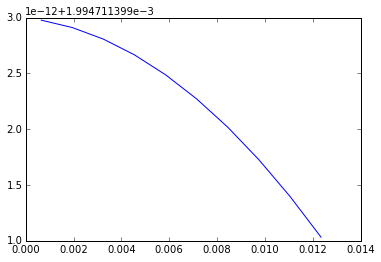

In [15]:
plt.plot(x, gauss_norm(x, -.001, 300, .005))

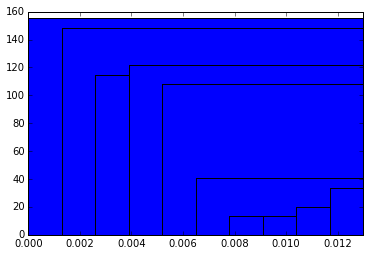

In [16]:
# find negative numbers 
for i in range(len(fluxtime_array)):
    if fluxtime_array[i] < 0:
        print(fluxtime_array[i])

plt.bar(bin_edges[:-1], p_hist, width = 1)
plt.xlim(min(bin_edges), max(bin_edges))
plt.show() 


<h2> Bayesian blocks

In [17]:
time_array = (MJD_array*100).astype(np.float64)
count_array = (fluxtime_array*10**7).astype(np.float64)

In [18]:
bayesian_blocks?

In [19]:
bin_edges = bayesian_blocks(time_array, count_array)

/Users/mbuchove/Programs/Anaconda3/anaconda/lib/python3.5/site-packages/astropy/stats/bayesian_blocks.py:421: UserWarning: p0 does not seem to accurately represent the false positive rate for event data. It is highly recommended that you run random trials on signal-free noise to calibrate ncp_prior to achieve a desired false positive rate.
  warnings.warn('p0 does not seem to accurately represent the false '


ValueError: x must be integer counts for fitness='events'

<h2> timings 

In [ ]:
from timeit import timeit 
%timeit sqrt(50000000000)
%timeit np.sqrt(50000000000)

In [ ]:
%timeit log(500)
%timeit np.log(500)